In [1]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import random
import argparse
import networkx as nx
from itertools import combinations
import time

In [2]:
%%capture
"""
Reproducing the results for WalkSAT/SKC. Same set of benchmark problems, 
performance metrics (TTS, i.e. #flips to solution, and/or #flips to solvability), 
hyperparameters (MAX_FLIP and random walk probability p), and the 
same sample size for a fair apple-to-apple comparison with previous work.
"""

In [3]:
def read_dimacs(filename): # int num_vars, array clauses
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                parts = line.strip().split()
                if len(parts) >= 4:
                    _, _, variables, _ = parts[:4]
                    num_vars = int(variables)
                else:
                    raise ValueError("Invalid CNF file format in 'p' line.")
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                # Remove the trailing 0 if present
                if clause and clause[-1] == 0:
                    clause = clause[:-1]
                if clause:
                    clauses.append(clause)
    return num_vars, clauses

In [4]:
def walkSAT(clauses, max_tries, max_flips, p): # assignment, _Tries, _Flips, flips
    flips = 0
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _Tries in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _Flips in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment, _Tries, _Flips, flips  # Found a satisfying assignment
            
            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip
                
                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)
            flips += 1

    return "FAIL"

In [6]:
num_vars, clauses = read_dimacs("/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5001.cnf")
start = time.perf_counter()
solution_object = walkSAT(clauses, 1, 1000, 0.5)
end = time.perf_counter()
if solution_object != "FAIL": #if we satisfied the problem
    time_to_solution = end-start #in seconds, time to solution
    flips_to_solution = solution_object[2]
    print(time_to_solution)
    print(flips_to_solution)
    

0.16276534396456555
850


Ok that was unreadable, let's do the first 100 like Tinish:

Total CPU cores: 64, Using 19 worker processes.
uf50085.cnf: Time = 0.0116s, Flips = 33uf500113.cnf: Time = 0.0121s, Flips = 61

uf50057.cnf: Time = 0.0231s, Flips = 146uf500183.cnf: Time = 0.0220s, Flips = 73uf500239.cnf: Time = 0.0220s, Flips = 59


uf50015.cnf: Time = 0.0274s, Flips = 87
uf500169.cnf: Time = 0.0309s, Flips = 97
uf50099.cnf: Time = 0.0335s, Flips = 192
uf500141.cnf: Time = 0.0397s, Flips = 116uf500184.cnf: Time = 0.0150s, Flips = 45

uf50016.cnf: Time = 0.0138s, Flips = 54uf50071.cnf: Time = 0.0424s, Flips = 221
uf500170.cnf: Time = 0.0097s, Flips = 26

uf500114.cnf: Time = 0.0311s, Flips = 156uf500240.cnf: Time = 0.0208s, Flips = 75

uf50043.cnf: Time = 0.0554s, Flips = 183
uf500225.cnf: Time = 0.0630s, Flips = 187uf500185.cnf: Time = 0.0221s, Flips = 66

uf50072.cnf: Time = 0.0364s, Flips = 178
uf500171.cnf: Time = 0.0540s, Flips = 191
uf500226.cnf: Time = 0.0352s, Flips = 108
uf50058.cnf: Time = 0.0794s, Flips = 447
uf5001.cnf: Time = 0.1399s, Flips = 440
uf50044.

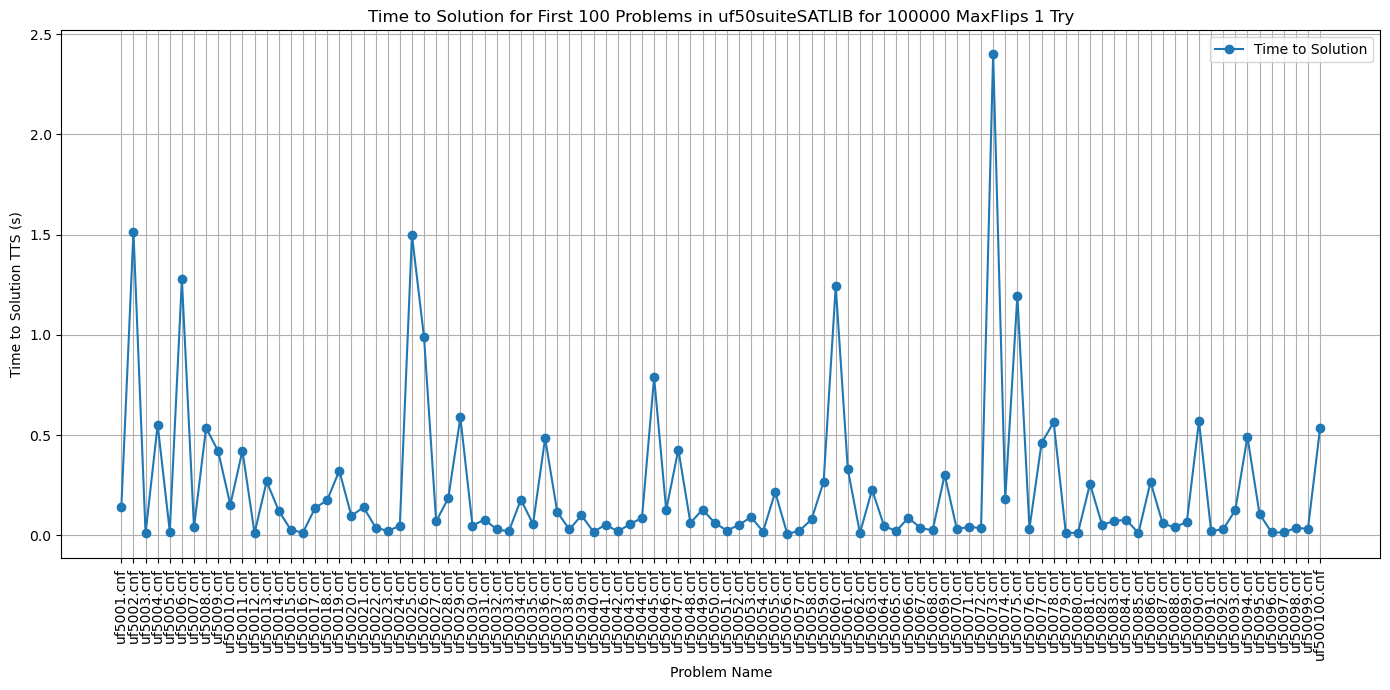

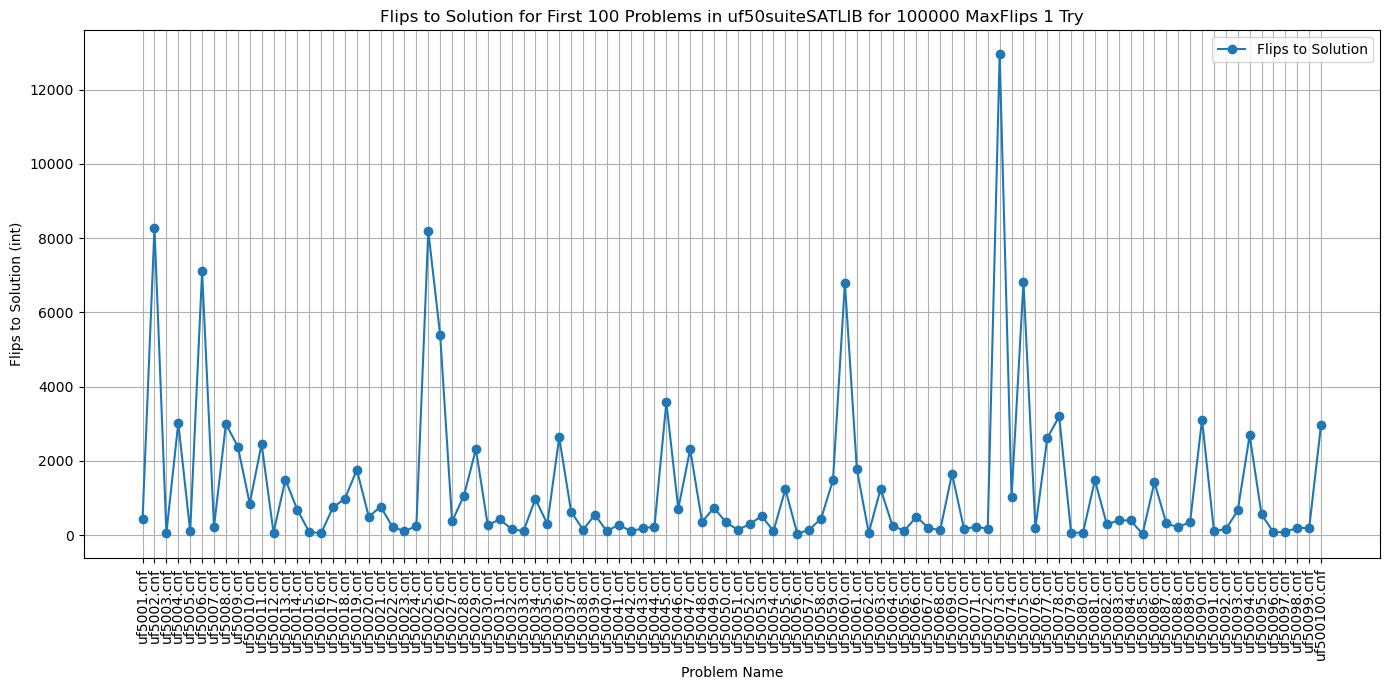

In [23]:
import os
import glob
import time
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

def extract_problem_number(filename) -> int:
    """Extract numerical problem number from filename."""
    basename = os.path.basename(filename)
    num_str = ''.join(filter(str.isdigit, basename)) # jank the digits
    return int(num_str)

def process_file(cnf_file):
    import time  # need if run in a separate process

    max_flips_var = 100000

    problem_name = os.path.basename(cnf_file)
    num_vars, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    solution_object = walkSAT(clauses, max_tries=1, max_flips=max_flips_var, p=0.5)
    end = time.perf_counter()

    if solution_object != "FAIL":  # we found a satisfying model
        time_to_solution = end - start  # seconds
        flips = solution_object[2]
        print(f"{problem_name}: Time = {time_to_solution:.4f}s, Flips = {flips}")
        return (problem_name, time_to_solution, flips)
    else:
        print(f"{problem_name}: Failed to find a solution")
        # Return None for time and flips (thanks George for suggestion)
        return (problem_name, None, None)

def main():
    problem_names = []
    times_to_solution = []
    flips_to_solution = []
    cnf_directory = "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf")) # get all uf50* files
    cnf_files.sort(key=extract_problem_number) # sort files based on  numerical part of the filename

    total_cpus = multiprocessing.cpu_count()
    num_workers = max(1, int(total_cpus * 0.3)) # use 30% of cores
    print(f"Total CPU cores: {total_cpus}, Using {num_workers} worker processes.")

    with multiprocessing.Pool(processes=num_workers) as pool: # do the benchmarking in parallel
        results = pool.map(process_file, cnf_files)

    if results:
        problem_names, times_to_solution, flips_to_solution = zip(*results)
    else:
        print("No results error.")
        return

    times_to_solution = np.array(times_to_solution, dtype=float)
    flips_to_solution = np.array(flips_to_solution, dtype=float)

    # take only the first 100 results to plot
    times_to_solution = times_to_solution[0:100]
    flips_to_solution = flips_to_solution[0:100]
    problem_names = problem_names[0:100]

    # Time to solution
    plt.figure(figsize=(14, 7))
    plt.plot(problem_names, times_to_solution, marker='o', linestyle='-', label='Time to Solution')
    plt.xlabel('Problem Name')
    plt.ylabel('Time to Solution TTS (s)')
    plt.title('Time to Solution for First 100 Problems in uf50suiteSATLIB for 100000 MaxFlips 1 Try')
    plt.xticks(rotation=90)
    plt.grid(True)

    failed_indices = np.where(np.isnan(times_to_solution))[0] # if there are any NaN solutions (fails) highlight them
    if failed_indices.size > 0:
        plt.scatter(np.array(problem_names)[failed_indices], 
                    np.zeros_like(failed_indices), 
                    color='red', marker='x', label='Failed to find a solution')

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Flips to solution
    plt.figure(figsize=(14, 7))
    plt.plot(problem_names, flips_to_solution, marker='o', linestyle='-', label='Flips to Solution')
    plt.xlabel('Problem Name')
    plt.ylabel('Flips to Solution (int)')
    plt.title('Flips to Solution for First 100 Problems in uf50suiteSATLIB for 100000 MaxFlips 1 Try')
    plt.xticks(rotation=90)
    plt.grid(True)

    if failed_indices.size > 0: # if there are any NaN solutions (fails) highlight them
        plt.scatter(np.array(problem_names)[failed_indices], 
                    np.zeros_like(failed_indices), 
                    color='red', marker='x', label='Failed to find a solution')

    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
